<a href="https://colab.research.google.com/github/jpan0829/Emotion-Detection-Simulation/blob/main/resnet50_of_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 96% 116M/121M [00:02<00:00, 45.2MB/s]
100% 121M/121M [00:02<00:00, 48.1MB/s]


In [ ]:
!unzip face-expression-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import SGD,RMSprop
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
path='images/'

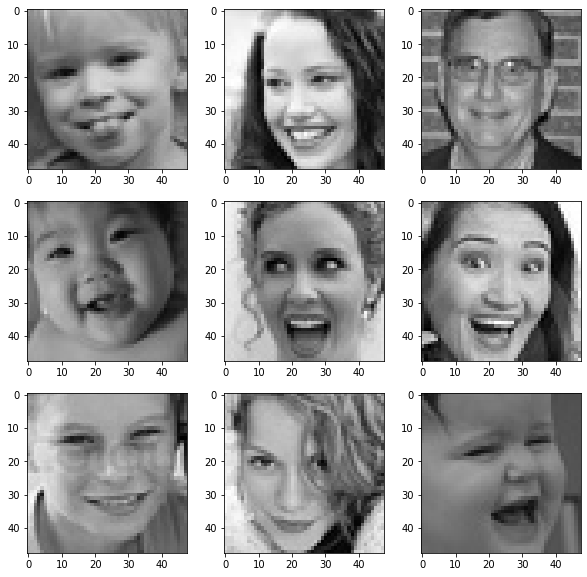

In [ ]:
expression = 'happy'

plt.figure(figsize= (10,10))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(path+"train/"+expression+"/"+
                  os.listdir(path + "train/" + expression)[i])
    plt.imshow(img)
plt.show()


In [ ]:
batch_size  = 128
picture_size = 48

gen_train  = ImageDataGenerator()
gen_val = ImageDataGenerator()

train = gen_train.flow_from_directory(path+"train",
                                       target_size = (picture_size,picture_size),
                                              #color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical')

val = gen_val.flow_from_directory(path+"validation",
                                    target_size = (picture_size,picture_size),
                                              #color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical')


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet')

# Taking the output of the last convolution block in ResNet50
x = base_model.output

# Adding a Global Average Pooling layer
x = GlobalAveragePooling2D()(x)

# Adding a fully connected layer having 1024 neurons
x = Dense(1024, activation='relu')(x)

predictions = Dense(7, activation='softmax')(x)

# Model to be trained
model = Model(inputs=base_model.input, outputs=predictions)

# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_6[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [ ]:
checkpoint = ModelCheckpoint("./model.res50", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#early_stopping = EarlyStopping(monitor='val_loss',
                          #min_delta=0,
                          #patience=5,
                          #verbose=1,
                          #restore_best_weights=True
                          #)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [checkpoint,reduce_learningrate]


model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
epochs = 50
process = model.fit_generator(generator=train,
                                steps_per_epoch=train.n//train.batch_size,
                                epochs=epochs,
                                validation_data = val,
                                validation_steps = val.n//val.batch_size,
                                callbacks=callbacks_list
                                )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.7970 - accuracy: 0.3827
Epoch 00001: val_accuracy improved from -inf to 0.40554, saving model to ./model.cnn
INFO:tensorflow:Assets written to: ./model.cnn/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


225/225 [==============================] - 44s 181ms/step - loss: 1.7970 - accuracy: 0.3827 - val_loss: 1.5309 - val_accuracy: 0.4055 - lr: 0.0010
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.4293 - accuracy: 0.4588
Epoch 00002: val_accuracy improved from 0.40554 to 0.42869, saving model to ./model.cnn
INFO:tensorflow:Assets written to: ./model.cnn/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


225/225 [==============================] - 40s 177ms/step - loss: 1.4293 - accuracy: 0.4588 - val_loss: 1.4863 - val_accuracy: 0.4287 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.3366 - accuracy: 0.4955
Epoch 00003: val_accuracy improved from 0.42869 to 0.43892, saving model to ./model.cnn
INFO:tensorflow:Assets written to: ./model.cnn/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


225/225 [==============================] - 40s 178ms/step - loss: 1.3366 - accuracy: 0.4955 - val_loss: 1.4928 - val_accuracy: 0.4389 - lr: 0.0010
Epoch 4/50
225/225 [==============================] - ETA: 0s - loss: 1.2554 - accuracy: 0.5288
Epoch 00004: val_accuracy improved from 0.43892 to 0.45440, saving model to ./model.cnn
INFO:tensorflow:Assets written to: ./model.cnn/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


225/225 [==============================] - 39s 175ms/step - loss: 1.2554 - accuracy: 0.5288 - val_loss: 1.4453 - val_accuracy: 0.4544 - lr: 0.0010
Epoch 5/50
225/225 [==============================] - ETA: 0s - loss: 1.1595 - accuracy: 0.5710
Epoch 00005: val_accuracy did not improve from 0.45440
225/225 [==============================] - 15s 69ms/step - loss: 1.1595 - accuracy: 0.5710 - val_loss: 1.4814 - val_accuracy: 0.4516 - lr: 0.0010
Epoch 6/50
225/225 [==============================] - ETA: 0s - loss: 1.0771 - accuracy: 0.6028
Epoch 00006: val_accuracy improved from 0.45440 to 0.45824, saving model to ./model.cnn
INFO:tensorflow:Assets written to: ./model.cnn/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


225/225 [==============================] - 39s 172ms/step - loss: 1.0771 - accuracy: 0.6028 - val_loss: 1.5022 - val_accuracy: 0.4582 - lr: 0.0010
Epoch 7/50
225/225 [==============================] - ETA: 0s - loss: 0.9843 - accuracy: 0.6419
Epoch 00007: val_accuracy improved from 0.45824 to 0.45895, saving model to ./model.cnn
INFO:tensorflow:Assets written to: ./model.cnn/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
225/225 [==============================] - 39s 174ms/step - loss: 0.9843 - accuracy: 0.6419 - val_loss: 1.5490 - val_accuracy: 0.4589 - lr: 0.0010
Epoch 8/50
225/225 [==============================] - ETA: 0s - loss: 0.7507 - accuracy: 0.7450
Epoch 00008: val_accuracy improved from 0.45895 to 0.48920, saving model to ./model.cnn
INFO:tensorflow:Assets written to: ./model.cnn/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


225/225 [==============================] - 40s 176ms/step - loss: 0.7507 - accuracy: 0.7450 - val_loss: 1.5089 - val_accuracy: 0.4892 - lr: 2.0000e-04
Epoch 9/50
225/225 [==============================] - ETA: 0s - loss: 0.6843 - accuracy: 0.7735
Epoch 00009: val_accuracy did not improve from 0.48920
225/225 [==============================] - 15s 68ms/step - loss: 0.6843 - accuracy: 0.7735 - val_loss: 1.5443 - val_accuracy: 0.4801 - lr: 2.0000e-04
Epoch 10/50
225/225 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.7916
Epoch 00010: val_accuracy did not improve from 0.48920

Epoch 00010: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
225/225 [==============================] - 15s 68ms/step - loss: 0.6407 - accuracy: 0.7916 - val_loss: 1.5564 - val_accuracy: 0.4889 - lr: 2.0000e-04
Epoch 11/50
225/225 [==============================] - ETA: 0s - loss: 0.5746 - accuracy: 0.8250
Epoch 00011: val_accuracy did not improve from 0.48920
225/225 [===

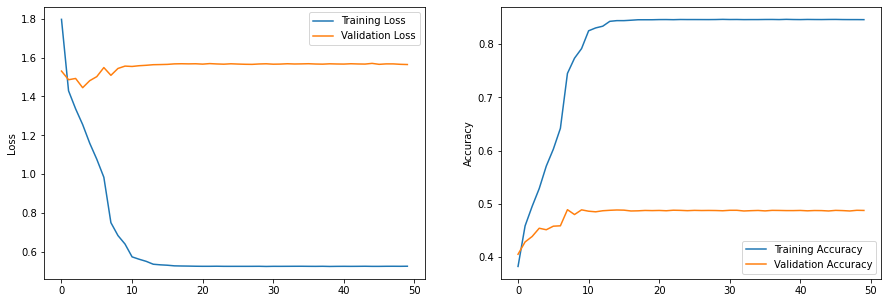

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.ylabel('Loss')
plt.plot(process.history['loss'], label='Training Loss')
plt.plot(process.history['val_loss'], label='Validation Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy')
plt.plot(process.history['accuracy'], label='Training Accuracy')
plt.plot(process.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='best')
plt.show()


In [ ]:
model.load_weights("./model.res50")

In [ ]:
Y_pred = model.predict(val, 7 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = ['angry', 'disgust', 'fear','happy','neutral','sad','suprise']
print(classification_report(val.classes, y_pred, target_names=target_names))


Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.10      0.11       960
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.12      0.13      1018
       happy       0.26      0.31      0.28      1825
     neutral       0.19      0.20      0.19      1216
         sad       0.15      0.15      0.15      1139
     suprise       0.11      0.11      0.11       797

    accuracy                           0.18      7066
   macro avg       0.14      0.14      0.14      7066
weighted avg       0.17      0.18      0.18      7066



In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

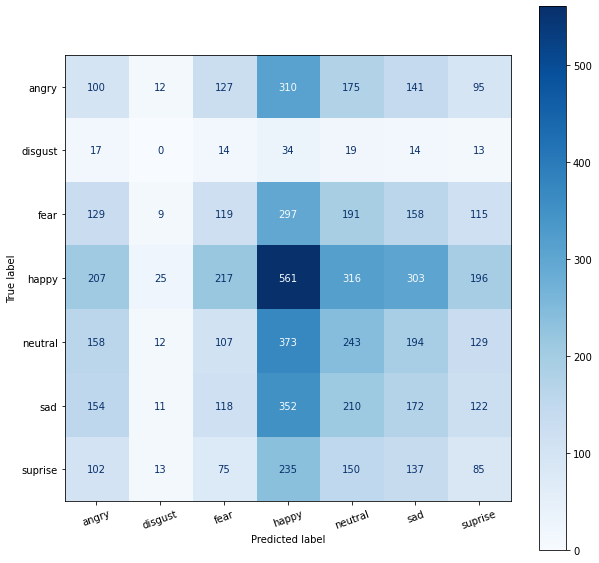

In [ ]:
plot_confusion_matrix(val.classes, y_pred, target_names)